In [2]:
import warnings


warnings.filterwarnings("ignore")  # avoid printing out absolute pat

In [5]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import (
    optimize_hyperparameters,
)

In [39]:
#!pip install pytorch_lightning

In [6]:
dataset = pd.read_excel('sample_data/dataset.xlsx', sheet_name='electdata')
dataset.columns = dataset.columns.astype(str)
dataset

,HouseID,cluster,2022-01-01 00:00:00,2022-01-01 01:00:00,2022-01-01 02:00:00,2022-01-01 03:00:00,2022-01-01 04:00:00,2022-01-01 05:00:00,2022-01-01 06:00:00,2022-01-01 07:00:00,...,2022-12-31 14:00:00,2022-12-31 15:00:00,2022-12-31 16:00:00,2022-12-31 17:00:00,2022-12-31 18:00:00,2022-12-31 19:00:00,2022-12-31 20:00:00,2022-12-31 21:00:00,2022-12-31 22:00:00,2022-12-31 23:00:00
0,1,2,717,926,431,558,436,511,1123,530,...,939,1316,1386,1239,3300,1772,3443,1991,2314,1956
1,3,7,772,769,856,741,638,628,612,5331,...,4928,2026,1354,2210,2526,3025,4364,2493,3769,1279
2,4,4,109,88,97,0,169,0,155,258,...,388,1441,1484,312,621,454,685,742,582,519
3,8,5,593,441,353,382,313,368,357,315,...,555,334,423,3492,2944,463,783,1330,2024,688
4,12,4,918,504,473,480,471,415,3564,5523,...,600,683,658,1283,1602,2239,1788,1955,1692,556
5,13,6,193,296,117,129,153,151,1761,11354,...,1862,367,446,550,713,641,1073,889,661,446
6,16,3,856,718,603,548,434,514,531,388,...,1048,815,410,486,787,998,1576,1315,1191,738
7,17,4,275,421,624,738,737,2127,521,4113,...,803,824,397,568,2656,1041,901,1008,3390,405
8,18,4,109,110,110,110,110,110,108,106,...,195,250,148,148,150,534,1661,1939,152,153
9,19,4,107,98,83,78,79,78,76,3022,...,855,483,300,276,2068,1050,857,694,774,1382


In [7]:
#data_cluster = dataset.iloc[:,1:].groupby('cluster').mean()
#df = data_cluster.T
#df
#print(dataset.iloc[:,1:].groupby('cluster').mean().T)

# Compute Mean & Std for Each Cluster per Timestep
data_cluster = dataset.iloc[:, 1:].groupby('cluster').agg(['mean', 'std'])

# Ensure MultiIndex is properly handled
df_mean = data_cluster.loc[:, pd.IndexSlice[:, 'mean']].droplevel(1, axis=1)
df_std = data_cluster.loc[:, pd.IndexSlice[:, 'std']].droplevel(1, axis=1)

# Transpose to get timesteps as rows
df_means = df_mean.T
df_std = df_std.T
df_means

cluster,1,2,3,4,5,6,7
2022-01-01 00:00:00,413.692308,716.50,608.333333,311.666667,510.333333,431.750,787.8
2022-01-01 01:00:00,340.923077,925.75,594.444444,627.500000,396.666667,426.625,1355.6
2022-01-01 02:00:00,293.307692,430.75,602.444444,326.555556,257.333333,413.625,1173.2
2022-01-01 03:00:00,305.538462,558.50,529.666667,324.277778,286.000000,432.750,784.8
2022-01-01 04:00:00,466.153846,435.50,474.111111,302.388889,322.333333,373.125,712.0
...,...,...,...,...,...,...,...
2022-12-31 19:00:00,536.153846,1185.25,1311.000000,1450.611111,663.666667,633.750,2868.4
2022-12-31 20:00:00,904.769231,1590.00,1725.444444,1467.388889,721.333333,826.375,4456.8
2022-12-31 21:00:00,620.153846,1332.25,2558.000000,1490.722222,1123.666667,676.000,2550.2
2022-12-31 22:00:00,690.230769,1652.50,1056.444444,1357.333333,1318.000000,543.500,3571.8


In [8]:
df_mean = df_means[[4]].copy()
data = df_mean
data

cluster,4
2022-01-01 00:00:00,311.666667
2022-01-01 01:00:00,627.500000
2022-01-01 02:00:00,326.555556
2022-01-01 03:00:00,324.277778
2022-01-01 04:00:00,302.388889
...,...
2022-12-31 19:00:00,1450.611111
2022-12-31 20:00:00,1467.388889
2022-12-31 21:00:00,1490.722222
2022-12-31 22:00:00,1357.333333


In [9]:
df_std

cluster,1,2,3,4,5,6,7
2022-01-01 00:00:00,299.789477,329.031407,380.017763,260.546936,98.052707,190.585376,82.850468
2022-01-01 01:00:00,230.053784,94.425897,316.738501,1188.267857,153.382963,146.090909,743.065811
2022-01-01 02:00:00,178.342080,236.385808,353.983090,238.394686,151.216181,211.418297,677.678168
2022-01-01 03:00:00,195.711359,255.845657,314.777302,223.612008,120.337027,225.360505,67.736253
2022-01-01 04:00:00,660.863809,203.938716,314.694473,200.972090,11.372481,181.684528,136.877683
...,...,...,...,...,...,...,...
2022-12-31 19:00:00,377.444443,418.319156,1222.957992,932.127051,173.785308,391.384265,352.612819
2022-12-31 20:00:00,1161.944645,1327.422063,717.175730,1200.226946,67.633818,660.256647,1046.117202
2022-12-31 21:00:00,551.300560,507.003205,1426.694694,755.609672,488.364959,420.153713,373.393492
2022-12-31 22:00:00,685.482088,610.314400,427.738270,1079.665526,614.859334,221.024239,2425.797127


In [10]:
df_mean.sample(10, random_state=521)

cluster,4
2022-05-06 16:00:00,2369.388889
2022-03-31 00:00:00,2903.611111
2022-03-21 06:00:00,1329.722222
2022-03-17 09:00:00,1309.611111
2022-09-02 21:00:00,2064.777778
2022-09-10 14:00:00,1449.222222
2022-01-19 15:00:00,643.888889
2022-12-10 17:00:00,1458.500000
2022-02-03 21:00:00,1024.666667
2022-08-22 14:00:00,861.722222


In [11]:
df_mean.describe()

cluster,4
count,8760.000000
mean,1288.556697
std,568.276951
min,238.500000
25%,876.166667
50%,1203.722222
75%,1595.402778
max,4457.222222


In [14]:
import pandas as pd
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from sklearn.preprocessing import StandardScaler
import torch

# Assuming you already loaded the dataframe
df = data
df["time_idx"] = range(len(df))  # sequential index
df["series_id"] = "cluster_4"  # identifier for the time series

df

cluster,4,time_idx,series_id
2022-01-01 00:00:00,311.666667,0,cluster_4
2022-01-01 01:00:00,627.500000,1,cluster_4
2022-01-01 02:00:00,326.555556,2,cluster_4
2022-01-01 03:00:00,324.277778,3,cluster_4
2022-01-01 04:00:00,302.388889,4,cluster_4
...,...,...,...
2022-12-31 19:00:00,1450.611111,8755,cluster_4
2022-12-31 20:00:00,1467.388889,8756,cluster_4
2022-12-31 21:00:00,1490.722222,8757,cluster_4
2022-12-31 22:00:00,1357.333333,8758,cluster_4


In [19]:
df = df.rename(columns={4: "value"})
df

cluster,value,time_idx,series_id
2022-01-01 00:00:00,311.666667,0,cluster_4
2022-01-01 01:00:00,627.500000,1,cluster_4
2022-01-01 02:00:00,326.555556,2,cluster_4
2022-01-01 03:00:00,324.277778,3,cluster_4
2022-01-01 04:00:00,302.388889,4,cluster_4
...,...,...,...
2022-12-31 19:00:00,1450.611111,8755,cluster_4
2022-12-31 20:00:00,1467.388889,8756,cluster_4
2022-12-31 21:00:00,1490.722222,8757,cluster_4
2022-12-31 22:00:00,1357.333333,8758,cluster_4


In [20]:
from pytorch_forecasting import TimeSeriesDataSet

max_encoder_length = 168  # past 7 days (if hourly)
max_prediction_length = 100  # next 100 time steps

training = TimeSeriesDataSet(
    df,
    time_idx="time_idx",
    target="value",
    group_ids=["series_id"],  # just one series
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=["value"]
)

In [28]:
#df = df.reset_index()
df = df.rename(columns={"index": "time"})
df

cluster,level_0,time,value,time_idx,series_id
0,0,2022-01-01 00:00:00,311.666667,0,cluster_4
1,1,2022-01-01 01:00:00,627.500000,1,cluster_4
2,2,2022-01-01 02:00:00,326.555556,2,cluster_4
3,3,2022-01-01 03:00:00,324.277778,3,cluster_4
4,4,2022-01-01 04:00:00,302.388889,4,cluster_4
...,...,...,...,...,...
8755,8755,2022-12-31 19:00:00,1450.611111,8755,cluster_4
8756,8756,2022-12-31 20:00:00,1467.388889,8756,cluster_4
8757,8757,2022-12-31 21:00:00,1490.722222,8757,cluster_4
8758,8758,2022-12-31 22:00:00,1357.333333,8758,cluster_4


In [30]:
from torch.utils.data import DataLoader

train_dataloader = training.to_dataloader(train=True, batch_size=64, num_workers=0)

In [55]:
import pandas as pd
import torch
from pytorch_lightning import Trainer
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from sklearn.preprocessing import StandardScaler
import pytorch_lightning
import pytorch_forecasting
from pytorch_forecasting import TemporalFusionTransformer
from lightning.pytorch import Trainer

model = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    loss=QuantileLoss(),
    log_interval=10,
)
dataloader = training.to_dataloader(train=True, batch_size=16)
tft = TemporalFusionTransformer.from_dataset(training)
print(type(trainer))
print(isinstance(tft, pytorch_lightning.LightningModule))
trainer = Trainer(max_epochs=1)
trainer.fit(model, train_dataloaders=dataloader)

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


<class 'pytorch_lightning.trainer.trainer.Trainer'>
False


INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 32     | train
4  | static_variable_selection          | VariableSelectionNetwork        | 0      | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.2 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528    | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [57]:
# Extract the last encoder window
encoder_data = df[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length].copy()
last_time_idx = encoder_data["time_idx"].max()

# Create empty decoder steps
prediction_data = pd.DataFrame({
    "series_id": "cluster_4",
    "time_idx": range(last_time_idx + 1, last_time_idx + 1 + max_prediction_length),
    "time": pd.date_range(start=encoder_data["time"].max(), periods=max_prediction_length + 1, freq="H")[1:],
    "value": 0
})
prediction_data["value_scaled"] = 0  # dummy value

# Combine
full_data = pd.concat([encoder_data, prediction_data], ignore_index=True)

In [63]:
predict_dataset = TimeSeriesDataSet(
    df,
    time_idx="time_idx",
    target="value",
    group_ids=["series_id"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=["value"]
)

In [64]:
predict_dataloader = predict_dataset.to_dataloader(train=False, batch_size=64)

In [65]:
# Step 9: Predict using the trained model
predictions = tft.predict(predict_dataloader)
print(f"Predictions shape: {predictions.shape}")

Predictions shape: torch.Size([141, 10])


In [68]:
actuals = torch.cat([y[0] for x, y in predict_dataloader], dim=0)

In [95]:

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from scipy.stats import wasserstein_distance
# Calculate error metrics
def calc_metrics(actual, pred):
    actual = actual.numpy()
    pred = pred.numpy()
    wd = wasserstein_distance(actual.flatten(), pred.flatten())
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mape = np.mean(np.abs((actual - pred) / actual)) * 100
    smape = 100 * np.mean(2 * np.abs(pred - actual) / (np.abs(actual) + np.abs(pred)))
    #r2 = R2Score()(torch.tensor(pred), torch.tensor(actual)).item()
    r2 = r2_score(actual, pred)
#print(f"R2: {r2:.4f}")
    return rmse, mae, mape, smape, r2,wd

rmse, mae, mape, smape, r2,wd = calc_metrics(actuals, predictions)
print(f"WD: {wd:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"sMAPE: {smape:.2f}%")
print(f"R2: {r2:.4f}")

print("Actuals shape:", actuals.shape)
print("Predictions shape:", predictions.shape)

WD: 496.7334
RMSE: 828.7192
MAE: 733.0292
MAPE: 153.86%
sMAPE: 179.25%
R2: -0.4611
Actuals shape: torch.Size([141, 10])
Predictions shape: torch.Size([141, 10])


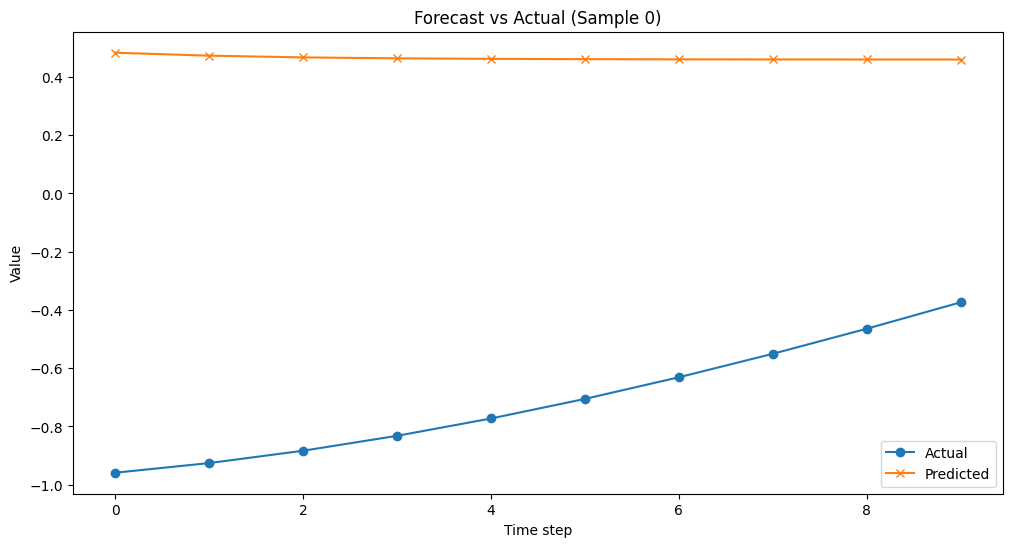

In [84]:
import matplotlib.pyplot as plt

# Convert tensors to numpy if needed
actual_np = actuals.numpy() if hasattr(actuals, "numpy") else actuals
pred_np = predictions.numpy() if hasattr(predictions, "numpy") else predictions

# Plot first sample's actual vs predicted
sample_idx = 0  # Change index to plot different samples if you want

plt.figure(figsize=(12, 6))
plt.plot(actual_np[sample_idx], label="Actual", marker='o')
plt.plot(pred_np[sample_idx], label="Predicted", marker='x')
plt.title(f"Forecast vs Actual (Sample {sample_idx})")
plt.xlabel("Time step")
plt.ylabel("Value")
plt.legend()
plt.show()


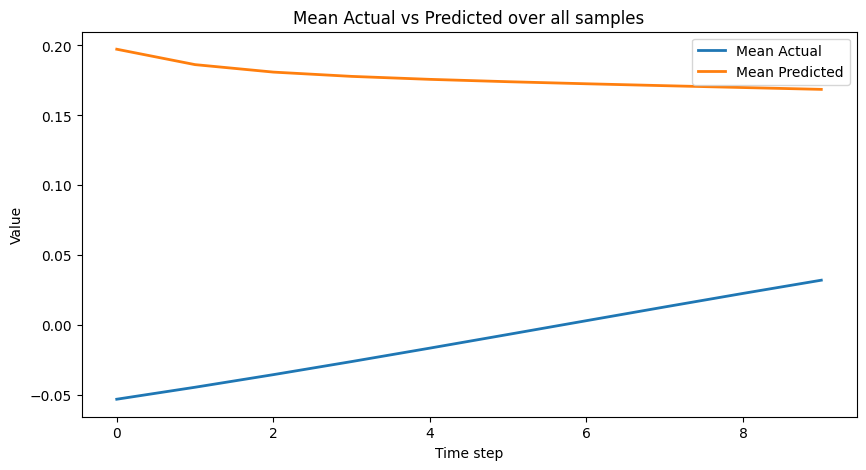

In [85]:
plt.figure(figsize=(10, 5))
plt.plot(actual_np.mean(axis=0), label="Mean Actual", linewidth=2)
plt.plot(pred_np.mean(axis=0), label="Mean Predicted", linewidth=2)
plt.title("Mean Actual vs Predicted over all samples")
plt.xlabel("Time step")
plt.ylabel("Value")
plt.legend()
plt.show()


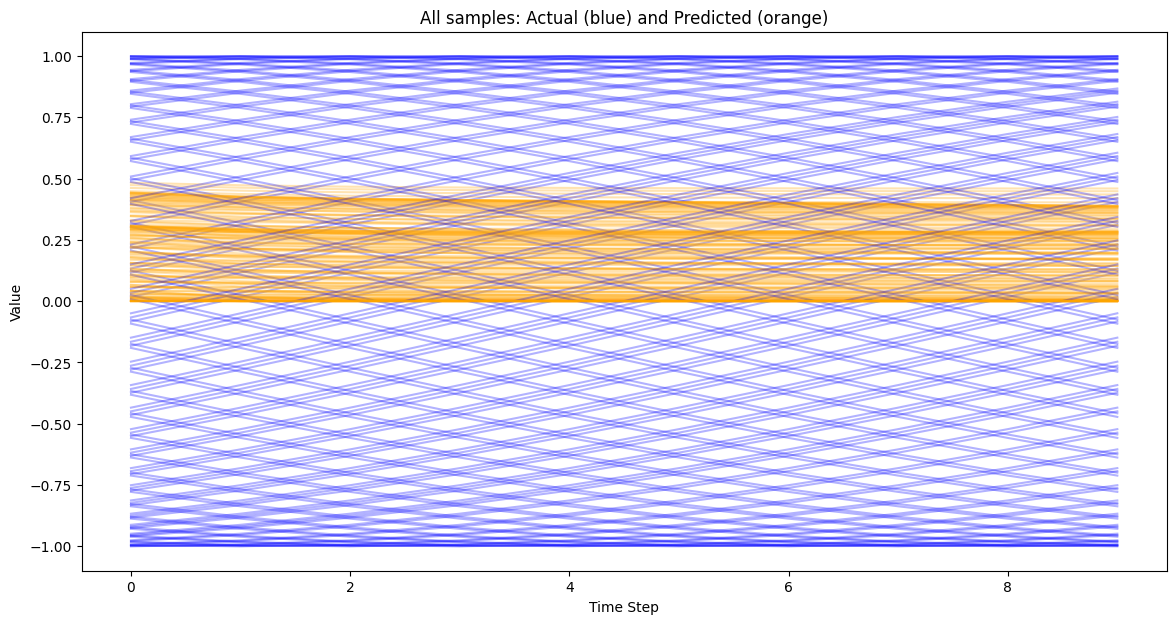

In [86]:
plt.figure(figsize=(14, 7))
for i in range(len(actual_np)):
    plt.plot(actual_np[i], alpha=0.3, color='blue')
    plt.plot(pred_np[i], alpha=0.3, color='orange')
plt.title("All samples: Actual (blue) and Predicted (orange)")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.show()


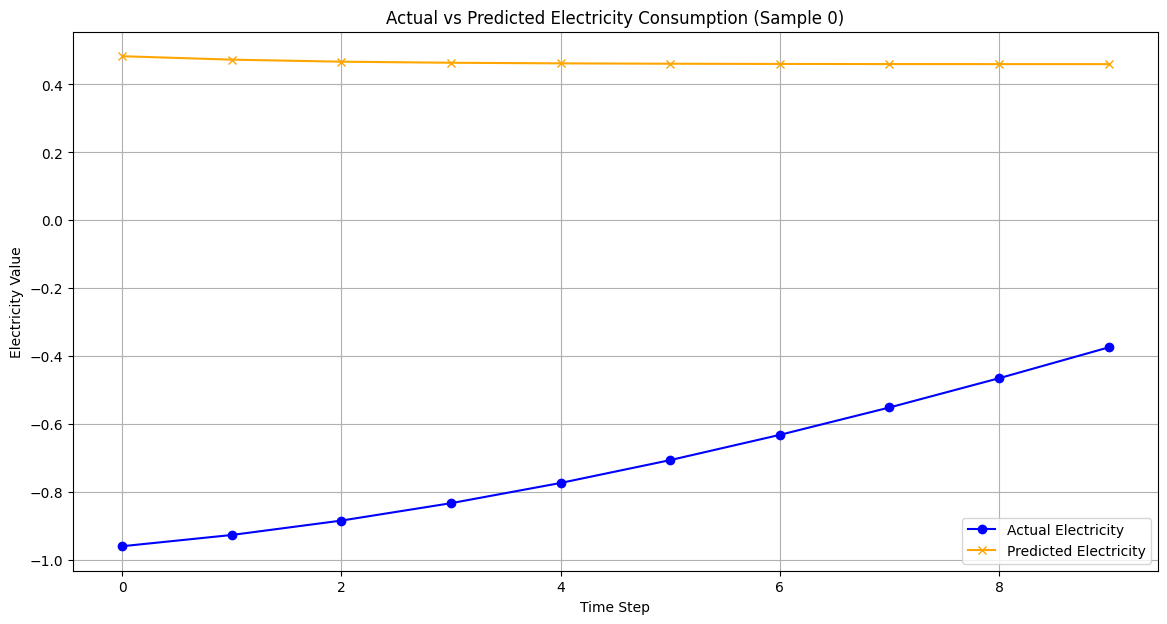

In [88]:
import matplotlib.pyplot as plt

# Convert tensors to numpy arrays if needed
actual_np = actuals.numpy() if hasattr(actuals, "numpy") else actuals
pred_np = predictions.numpy() if hasattr(predictions, "numpy") else predictions

sample_idx = 0  # or pick whichever sample you want

time_steps = range(len(actual_np[sample_idx]))  # 0 to number of timesteps

plt.figure(figsize=(14, 7))
plt.plot(time_steps, actual_np[sample_idx], label="Actual Electricity", marker='o', color='blue')
plt.plot(time_steps, pred_np[sample_idx], label="Predicted Electricity", marker='x', color='orange')
plt.title(f"Actual vs Predicted Electricity Consumption (Sample {sample_idx})")
plt.xlabel("Time Step")
plt.ylabel("Electricity Value")
plt.legend()
plt.grid(True)
plt.show()
